In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import glob as glob
import os as os
import ot
from scipy.stats import skew
import seaborn as sb
import geochron as geochron
from scipy.stats import ks_2samp
import math
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import colors
from matplotlib import cm
from scipy.optimize import curve_fit
from sklearn.decomposition import PCA
import matplotlib.patheffects as pe
import warnings
np.random.seed(0) # Set seed
pd.options.mode.chained_assignment = None  # default='warn'

## 1. Insert your data here

In [2]:
# Insert ages here - demo data from Szymanowski et al. (2023)
ages = [0.151, 0.284, 0.293, 0.195, 0.237, 0.21 , 0.367, 0.546, 0.941,
       0.194, 0.422, 0.219, 0.29 , 0.242, 0.319, 0.269, 0.267, 0.138,
       0.217, 0.327, 0.206, 0.263, 0.359, 0.303, 0.449, 0.138, 0.365,
       0.261, 0.142]

# Insert uncertainties here 2s
unc = [0.006, 0.005, 0.005, 0.007, 0.006, 0.005, 0.004, 0.006, 0.005,
       0.005, 0.005, 0.006, 0.005, 0.006, 0.005, 0.005, 0.005, 0.007,
       0.006, 0.005, 0.007, 0.006, 0.01 , 0.005, 0.015, 0.01 , 0.008,
       0.007, 0.006]


## 2. Filter the dataset

/Users/cnathwani/Desktop/Python_Projects/zircon_age_spectra/scripts/geochron.py:107: RuntimeWarning: divide by zero encountered in true_divide
  gradient_ecdf = dy/dx


Filtered ages: [0.941]


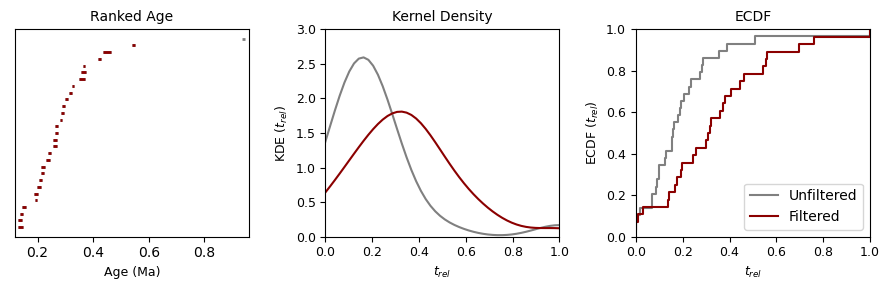

In [3]:
ages = np.array(ages)
ind = ages.argsort()
ages = ages[ind]
unc = np.array(unc)[ind]

ages_fil, unc_fil = geochron.filter_older_ages(age_dist=ages, unc=unc, weighted = False)

print('Filtered ages:', str(np.setdiff1d(ages, ages_fil)))



fig, axs = plt.subplots(1,3, figsize = (9,3))

axs[0].hlines(y = range(len(ages)), xmin =  ages-unc, 
                     xmax = ages+unc, linewidth = 2, color = 'gray')

axs[0].hlines(y = range(len(ages_fil)), xmin =  ages_fil-unc_fil, 
                     xmax = ages_fil+unc_fil, linewidth = 2, color = 'darkred')


# unfiltered
ages_kde = geochron.plot_kde(ages,unc, normalize = True)
axs[1].plot(ages_kde[0],ages_kde[1], color = 'gray', label = 'Unfiltered')
axs[2].step(geochron.ecdf(ages)[0], geochron.ecdf(ages)[1], where = 'post', label = 'Unfiltered', c = 'gray')

# filtered

ages_kde = geochron.plot_kde(ages_fil, unc_fil, normalize = True)
axs[1].plot(ages_kde[0],ages_kde[1], color = 'darkred', label = 'Filtered')
axs[2].step(geochron.ecdf(ages_fil)[0], geochron.ecdf(ages_fil)[1], where = 'post', label = 'Filtered', c = 'darkred')

axs[0].set_xlabel('Age (Ma)', fontsize = 9)

axs[0].set_yticks([])
axs[0].set_xlim(np.min(ages)-0.02,np.max(ages)+0.02)


axs[1].set_ylabel('KDE ($t_{rel}$)', fontsize = 9)
axs[1].set_xlabel('$t_{rel}$', fontsize = 9)

axs[2].set_ylabel('ECDF ($t_{rel}$)', fontsize = 9)
axs[2].set_xlabel('$t_{rel}$', fontsize = 9)

axs[1].set_xlim([0,1])
axs[1].set_ylim([0,3.0])
axs[2].set_xlim([0,1])
axs[2].set_ylim([0,1])

axs[1].xaxis.set_tick_params(labelsize = 9)
axs[2].xaxis.set_tick_params(labelsize = 9)
axs[0].yaxis.set_tick_params(labelsize = 9)
axs[1].yaxis.set_tick_params(labelsize = 9)
axs[2].yaxis.set_tick_params(labelsize = 9)

axs[0].set_title('Ranked Age', fontsize = 10)
axs[1].set_title('Kernel Density', fontsize = 10)
axs[2].set_title('ECDF', fontsize = 10)

axs[2].legend()

plt.tight_layout()
plt.show()

## 3. See where your data plots relative to other age distributions

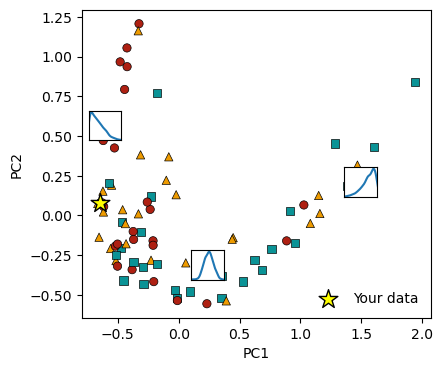

In [4]:
fig, axs = plt.subplots(1,1, figsize = (4.5,4))

colors = [(10/255, 147/255, 150/255),(174/255, 32/255, 18/255),(238/255, 155/255, 0/255)]
shapes = ['s','o','^']

pca_W2_data = geochron.generate_pca_scores()

sb.scatterplot(x=pca_W2_data['PC1'],y=pca_W2_data['PC2'],hue = pca_W2_data['Type'], style = pca_W2_data['Type'], markers = shapes,
              edgecolor = 'black', palette = colors, ax = axs, legend = False)

axs.set_xlabel('PC1')
axs.set_ylabel('PC2')

numValues = 1000
maxValue = 1
skewness = -10   #Negative values are left skewed, positive values are right skewed.

size_x = 0.27
size_y = 0.185

example_skews = [-100,0,100]

for skew in example_skews:
    x = stats.skewnorm.rvs(a = skew,loc=maxValue, size=numValues)  #Skewnorm function
    x = x - min(x)      #Shift the set so the minimum value is equal to zero.
    x = x / max(x)      #Standadize all the vlues between 0 and 1. 
    x = x * maxValue         #Multiply the standardized values by the maximum value.
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        pc1, pc2 = geochron.calc_W_PCA(x, np.ones(len(x)))
    
    ax = inset_axes(axs, "100%", "100%", 
                    bbox_to_anchor=(pc1-(size_x/2), pc2-(size_y/2), size_x, size_y),
                    bbox_transform=axs.transData, loc="center")
    
    sb.kdeplot(x, ax = ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_xlim([0,1])

x = np.linspace(0,1,10000)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

pc1, pc2 = geochron.calc_W_PCA(ages_fil, unc_fil)

axs.scatter(pc1, pc2, s = 200, color = 'yellow', marker = '*', edgecolor = 'black', label = 'Your data')

legend = axs.legend(loc = 4, frameon = False)
plt.rcParams['svg.fonttype'] = 'none'
plt.show()

In [8]:
conda env export > environment.yml


Note: you may need to restart the kernel to use updated packages.
